# Deteting Sarcasam in Reddit Comments

In [1]:
'''Importing Required Libraries '''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('train-balanced-sarcasm.csv')

In [3]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [5]:
'''53 Missing Values in Comments. 
This is very miniscule and can be ignored since the size of our dataset is quite large
'''
df.isna().sum()
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010773 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [6]:
'''
We want to see which subreddit contains the most data points, in this case there isnt one sub-reddit which 
contains a majority. As seen below the highest is 6% from the subreddit 'AskReddit'. in this case there is no 
need to subset our data since the labels are well spread betweeen all the subreddit
'''

(df['subreddit'].value_counts()[df['subreddit'].value_counts()>5000]/len(df['label']) * 100)

AskReddit          6.497403
politics           3.907208
worldnews          2.609488
leagueoflegends    2.080982
pcmasterrace       1.878463
funny              1.774780
news               1.671097
pics               1.597985
todayilearned      1.400809
nfl                1.399820
nba                1.399523
GlobalOffensive    1.359158
AdviceAnimals      1.333831
videos             1.218869
gaming             1.177910
The_Donald         0.953330
WTF                0.945613
hockey             0.869038
soccer             0.836587
TumblrInAction     0.743589
atheism            0.729837
CFB                0.697288
movies             0.648019
DotA2              0.591626
technology         0.563133
creepyPMs          0.540774
india              0.524252
gifs               0.521086
DestinyTheGame     0.497738
Name: subreddit, dtype: float64

In [7]:
'''
looking at the labels to make sure they are evenly distrubted
'''
df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [8]:
'''
We are inspecting the Data to see what the % is for subreddits that contain label 1 compared to the total number
of comments.
'''
df.groupby('subreddit')['label'].sum()/df['subreddit'].value_counts()*100

07Scape            0.000000
0x10c            100.000000
0x3642             0.000000
100DaysofKeto      0.000000
100pushups         0.000000
                    ...    
zoophilia        100.000000
zootopia          37.333333
zweiteliga       100.000000
zyramains         60.000000
zyzz              50.000000
Length: 14876, dtype: float64

In [9]:
df['score'].value_counts()

 1       339997
 2       162669
 3        90287
 0        58141
 4        41978
          ...  
 1448         1
 1221         1
 709          1
-87           1
 5629         1
Name: score, Length: 1291, dtype: int64

'\nBased on the Boxplot we can see that there is no real impact on whether a comment is sarcastic or not based on the score\ntherefore using scores would not be a effective way to detect sarcasam in comments.\n\n'

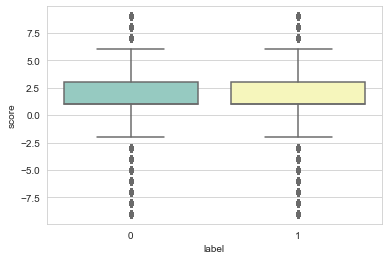

In [10]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="label", y="score",              
data=df[abs(df['score'])<10], palette="Set3")
'''
Based on the Boxplot we can see that there is no real impact on whether a comment is sarcastic or not based on the score
therefore using scores would not be a effective way to detect sarcasam in comments.

'''

In [11]:
df['score'].describe()

count    1.010773e+06
mean     6.885999e+00
std      4.834411e+01
min     -5.070000e+02
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      9.070000e+03
Name: score, dtype: float64

- Based on the Above analysis we can say that the only real way to detect sarcasam is through the comment alone.
- Will take 100k subset to test out pre-proccessing

In [23]:
df2 = df.loc[:10000,['label', 'comment']]
df2

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.
...,...,...
9996,1,Dog filter=giving up?
9997,1,Saturday Night dead amirite?
9998,1,"Moderators, not fact checkers."
9999,1,She hacked the online votes


In [24]:
df2['comment'] = df2['comment'].apply(lambda x: x.lower())

In [28]:
df2.head()

,label,comment
0,0,nc and nh.
1,0,you do know west teams play against west teams...
2,0,"they were underdogs earlier today, but since g..."
3,0,"this meme isn't funny none of the ""new york ni..."
4,0,i could use one of those tools.


In [27]:
df2.loc[:10, 'comment'].str.get_dummies(sep=' ')

,"""new",(before,-1,a,"afternoon,",against,amount,and,announcement,are.,...,underdogs,use,vegas,weird...,were,west,would,wouldn't,york,you
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,1,0,1,0,0,0,1,0,...,1,0,1,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [20]:
# for n in df['comment']:
#     print(n.lower())

In [15]:
pd.get_dummies(df.loc[:5,'comment'])

,I could use one of those tools.,"I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)",NC and NH.,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1","This meme isn't funny none of the ""new york nigga"" ones are.",You do know west teams play against west teams more than east teams right?
0,0,0,1,0,0,0
1,0,0,0,0,0,1
2,0,0,0,1,0,0
3,0,0,0,0,1,0
4,1,0,0,0,0,0
5,0,1,0,0,0,0
